In [1]:
import csv
import pandas as pd
import math
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import keras
import numpy as np
import sys 
from sklearn import svm
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.metrics import f1_score

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import Model
from sklearn.datasets import make_multilabel_classification
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import torch.optim as optim
#from keras.applications.imagenet_utils import decode_predictions
#from keras.applications.resnet50 import preprocess_input, decode_predictions

In [3]:
cuda =True

In [4]:
pho_path = './data/train_photos'
bus_path = './data/train.csv'
pho_label = 'photo_tag.csv' 
pho_bus = './data/train_photo_to_biz_ids.csv'

In [5]:
#############read the train business we need for classification
#############we can first get 1500 of them as training set and 500 of them as validation set
bus = pd.read_csv(bus_path)
img_tag = pd.read_csv(pho_label)
img_bus = pd.read_csv(pho_bus)

In [6]:
######separate training and testing set based on the business_id
train = list(bus.head(1500)['business_id'])
test = list(bus.head(500)['business_id'])
total = list(bus['business_id'])
total_label = list(bus['labels'])

In [7]:
#########filter the business, remove every business with zero label and zero image
def filter_business(total_business,total_label):
    new_bus = []
    new_label = []
    for t_b,t_l in zip(total_business,total_label):
        if type(t_l) == float or len(img_bus.loc[img_bus['business_id']==t_b])==0:
            continue
        else:
            new_bus.append(t_b)
            new_label.append(t_l)
    return new_bus,new_label

In [8]:
total,total_label = filter_business(total,total_label)

In [9]:
def progressBar(value, endvalue, bar_length=40):
    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\rPercent: [{0}] {1}%".format(arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

In [10]:
##############this is used to get the feature img from flattern layer based on each business
##############we only collect img_num photos, when the number of photos < img_num, we collect all of them
def collect_map(model_extractfeatures,business_id,img_num):
    bus_feature = []
    img_list = list(img_bus.loc[img_bus['business_id']==business_id]['photo_id'])
    img_set = []
    if len(img_list)>img_num:
        num = img_num
    else:
        num = len(img_list)
    for img in img_list[:num]:
        
        test_img = cv2.imread(pho_path+'/'+str(img)+'.jpg')
        x = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
        x = cv2.resize(x,(224,224))
        
        bus_feature.append(x)
    bus_feature = model_extractfeatures.predict(np.array(bus_feature))
    bus_feature = np.reshape(bus_feature,(bus_feature.shape[0],bus_feature.shape[1]*bus_feature.shape[2]*bus_feature.shape[3]))
    #bus_feature = np.array(bus_feature)
    #img_set = np.array(img_set)
    #img_set = np.reshape(img_set,(img_set.shape[0],224,224,3))
    #bus_feature = model_extractfeatures.predict(img_set)
    #################return the set of feature and the number of photo for each business
    return bus_feature,len(bus_feature)#np.array(bus_feature)
        

In [11]:
#########the bus_feature should be 2-dimension
#########this is used to reduce the dimension for each image
#########the business here is a set of business, this function will return the reduaction dimension feature for all images
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
def bus_red(business,model_extractfeatures,red_dim,img_num):
    ###########used for count the number od the business to make sure the program work fine
    count = 1
    
    #reduce = PCA(n_components=red_dim)
    feature_map,num = collect_map(model_extractfeatures,business[0],img_num)
    #print(count)
    progressBar(count,len(business))
    count+=1
    
    #############################
    photo_num = []  ####the number of photos for different business
    photo_num.append(num)
    for b in business[1:]:
        bus_feature,num = collect_map(model_extractfeatures,b,img_num)
        photo_num.append(num)
        feature_map = np.vstack((feature_map,bus_feature))
        #print(count)
        progressBar(count,len(business))
        count+=1
        
    ########now we have all the feature map with size n X 25088, n is the total image numbers 
    if len(feature_map)<red_dim:
        print('There are only {0:10} images, less than {1:10d}'.format(len(feature_map), red_dim))
        
    #reduce = reduce.fit(feature_map)
    #red_feature = reduce.transform(feature_map)
    
    ######when we don't use PCA
    red_feature = feature_map
    return red_feature,photo_num#pca.components_


def gather_feature(business,model_extractfeatures,img_num):
    ###########used for count the number od the business to make sure the program work fine
    count = 1
    total_feature = [] 
    #reduce = PCA(n_components=red_dim)
    feature_map,num = collect_map(model_extractfeatures,business[0],img_num)
    #print(count)
    progressBar(count,len(business))
    total_feature.append(feature_map)
    count+=1
    
    #############################
    photo_num = []  ####the number of photos for different business
    photo_num.append(num)
    for b in business[1:]:
        bus_feature,num = collect_map(model_extractfeatures,b,img_num)
        photo_num.append(num)
        #feature_map = np.vstack((feature_map,bus_feature))
        total_feature.append(bus_feature)
        #print(count)
        progressBar(count,len(business))
        count+=1
        
    
    return total_feature#pca.components_

In [12]:
################used to get the final feature for each business
def get_bus_map(red_feature):
    return red_feature.sum(axis=0)/float(red_feature.shape[0])

In [13]:
############# one hot here should be multi hot :)
def get_one_hot(total_label):
    labels = []
    count = 0
    for t_l in total_label:
        l = [0 for i in range(9)]
        #print(count)
        for t in t_l.split(' '):
            #print(t)
            l[int(t)]=1
        count+=1
        labels.append(l)
    return labels

In [14]:
def F1_score(test_y,predict_y):
    tp = (test_y*predict_y).sum(axis=1)
    fp=[]
    fn=[]
    F1 = []
    for t_y,p_y in zip(test_y,predict_y):
        
        F1.append(f1_score(np.array(t_y), np.array(p_y), average='macro') )
    
    F1 = np.array(F1)
    F1_final = F1.sum()/len(F1)
    return F1,F1_final

In [15]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
input_size = 25088 ########default feature size for VGG
output = 9
class model_dnn(nn.Module):
    #####the layer should cntain the size for each layer including input and output
    #####the hidden layer should have 3 layers
    def __init__(self, dropout=0, hidden1=2048, hidden2 = 1024 , hidden3 = 256, hidden4 = 128, output=9, 
                 num_layers=1, input_size = input_size ,type_model='LSTM'):
        super(model_dnn, self).__init__()
        
        #self.word_embeddings = nn.Embedding(len(char2idx), Embedding_size)
        self.hidden1 = hidden1
        #if type_model=="LSTM":
        self.rnn=nn.LSTM(
                        input_size=input_size,
                        hidden_size=hidden1,
                        num_layers=num_layers,
                        dropout=dropout)
        self.trans = nn.Linear(input_size,hidden1)
        
        self.dense1 = nn.Linear(hidden1,hidden2)
        self.regular = nn.Linear(hidden2,hidden3)
        self.atten = nn.Linear(hidden2,hidden3)
        #self.mult = torch.mm(hidden3,hidden3)
        self.dense4 = nn.Linear(hidden3,hidden4)
        self.last = nn.Linear(hidden3,output)
        
        
        self.dense2 = nn.Linear(hidden2+hidden1,hidden3)
        self.dense3 = nn.Linear(hidden3+hidden2,output)
        
        #self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.type_model=type_model
        #self.init_hidden()
        
    def forward(self, input_feature):
        x1, new_hidden = self.rnn(input_feature)
        
        #########second layer
        x2 = self.dense1(x1)
        
        ######### multiply 
        reg = self.regular(x2)
        att = self.atten(x2)
        
        mult = torch.mul(reg,att)  ##1 X N X 256
        
        ######get sum
        sum_f = torch.sum(mult,dim=1) ##1 X 1 X 256
        #x4 = self.dense4(sum_f)
        x5 = self.last(sum_f) ##1 X 1 X 9
        
        return x5#,new_hidden
    
    def init_hidden(self):
        if self.type_model=="LSTM":
            self.hidden = (Variable(torch.zeros(self.num_layers,1,self.hidden1).cuda())
                        ,Variable(torch.zeros(self.num_layers,1,self.hidden1)).cuda())
        else:
            self.hidden = Variable(torch.zeros(self.num_layers,1,self.hidden1).cuda())
    

def var(x,option):
    ####after this the x should have 3 dimension
    x = Variable(torch.from_numpy(np.array([x]))).float()
    if cuda and option == 'keras':
        return x.cuda()
    else:
        return x

In [16]:
############transform the output from probability to one-hot vector
############define a threshold to set the label as 1 with probability higher than threshold
def get_result(output,threshold = None):
    out = []
    #print()
    if len(list(output.size())) == 1:
        ave = output.data.numpy().sum()/9
        for r in output.data.numpy():
            if r<ave:
                out.append(0)
            else:
                out.append(1)
        return np.array([out])
    
    if threshold == None:
        ####use the average of each output set
        for o in output:
            ave = o.data.numpy().sum()/9
            hot = []
            for r in o.data.numpy():
                if r<ave:
                    hot.append(0)
                else:
                    hot.append(1)
            out.append(hot)
    else:
        for o in output:
            hot = []
            for r in o.data.numpy():
                if r<threshold:
                    hot.append(0)
                else:
                    hot.append(1)
            out.append(hot)
    return out

In [17]:
##################this is the part for model training and testing
#################it should return the F1 score for both training and testing set in this epoch
def training_model(model,option,criterion,optimizer,train_feature,train_label,test_feature,test_label,start,end):
    F1_train = []
    train_loss = []
    #print('train')
    for t_f,t_l in zip(train_feature[start:end],train_label[start:end]):
        t_l = np.array(t_l)
        #t_l = np.tile(t_l,(len(t_f),1))
        if option == 'pytorch':
            #############forward
            #output,_ = model(var(t_f,option))
            output = model(var(t_f,option))
            
            #print(output[0][-1])
            #############backward
            
            loss = criterion(output[0],var(t_l,option)[0])
            train_loss.append(loss.data[0])
            loss.backward()
            optimizer.step()
            out = get_result(output[0])
            
        if option == 'keras':
            t_f = np.reshape(t_f,(t_f.shape[0],1,t_f.shape[1]))
            #########forward
            output = model.predict(var(t_f,option))
            
            #########backward
            #print(np.array(t_l).shape)
            #print(t_f.shape)
            model.fit(var(t_f,option), var(t_l,option))
            loss = model.evaluate(var(t_f,option),var(t_l,option))
            out = get_result(output)
            
        #######change output to one-hot vector
        
        
        if len(t_l.shape)==1:
            t_l = np.reshape(t_l,(t_l.shape[0],1))
        
        #print(out,t_l)
        F_t = F1_score(np.array(out),t_l.T)[1]
        #print(F_t)
        F1_train.append(F_t)
    
    ############for test set
    F1_test = []
    test_loss = []
    #print('test')
    for t_f,t_l in zip(test_feature,test_label):
        t_l = np.array(t_l)
        #t_l = np.tile(t_l,(len(t_f),1))
        if option == 'pytorch':
            #############forward
            #output,_ = model(var(t_f,option))
            output = model(var(t_f,option))
            
            loss = criterion(output[0],var(t_l,option)[0])
            test_loss.append(loss.data[0])
            
            #######change output to one-hot vector
            out = get_result(output[0])
            
        if option == 'keras':
            t_f = np.reshape(t_f,(t_f.shape[0],1,t_f.shape[1]))
            #########forward
            output = model.predict(var(t_f,option))
            
            #######change output to one-hot vector
            out = get_result(output)
            
            #########backward
            loss = model.evaluate(var(t_f,option),var(t_l,option))
        
         
        
        if len(t_l.shape)==1:
            t_l = np.reshape(t_l,(t_l.shape[0],1))    
        
        
        F_t = F1_score(np.array(out),t_l.T)[1]
        #print(F_t)
        F1_test.append(F_t)
    
    return np.array(F1_train).sum()/len(F1_train),np.array(train_loss).sum()/len(train_loss),np.array(F1_test).sum()/len(F1_test),np.array(test_loss).sum()/len(test_loss),model

In [18]:
###########the model should be model_rnn
##########batch represent the number of training set for every epoch
##########every time when it finished we test the model with testing set  
def train_rnn(model,option,model_name,optimizer,train_feature,train_label,test_feature,test_label,batch):
    F1_train = []
    F1_test = []
    train_loss_set = []
    test_loss_set = []
    #####train the model
    criterion = nn.BCEWithLogitsLoss()
    
    #######least_loss
    
    #####t_f represent the features for every business_id
    print('Begin training')
    count = 1
    dif_test_loss = float('inf')  # the difference between the previous test_loss and current test loss
    while 1:
        
        start = 0
        end = batch
        if count%10 == 0 and option == 'pytorch':
            ###############save the model every 10 epoch
            torch.save(model, model_name+'.pt')
            
        if count%10 == 0 and option == 'keras':
            ###############save the model every 10 epoch
            model.save(model_name+'.h5')
            
        while end<len(train_label):
            
            F1_train_score,train_loss,F1_test_score,test_loss,model = training_model(model,option,criterion,optimizer,
                                                                                     train_feature,train_label,test_feature,
                                                                                     test_label,start,end)
            F1_train.append(F1_train_score)
            F1_test.append(F1_test_score)
            train_loss_set.append(train_loss)
            test_loss_set.append(test_loss)
            
            print('epoch {0:1d}, F1_test_score {1:1f}, train_loss {2:1f}, test_loss {3:1f}'.
                  format(count,F1_test_score,train_loss,test_loss))
            ###############update the data for next epoch training set
            start = end
            if end+batch>=len(train_label):
                end = len(train_label)  ###reach the end of the data set
                count+=1
                break
            else:
                end += batch
            count+=1
            
            if len(test_loss_set)>10 and test_loss_set[-1]>test_loss_set[-5]:
                break
                
        if len(test_loss_set)>10 and test_loss_set[-1]>test_loss_set[-5]:
            break
        
        if end == len(train_label):
            F1_train_score,train_loss,F1_test_score,test_loss,model = training_model(model,option,criterion,optimizer,
                                                                                     train_feature,train_label,test_feature,
                                                                                     test_label,start,end)
            F1_train.append(F1_train_score)
            F1_test.append(F1_test_score)
            train_loss_set.append(train_loss)
            test_loss_set.append(test_loss)
            
            print('epoch {0:1d}, F1_test_score {1:1f}, train_loss {2:1f}, test_loss {3:1f}'.
                   format(count,F1_test_score,train_loss,test_loss))
            count+=1
        if len(test_loss_set)>10 and test_loss_set[-1]>test_loss_set[-5]:
            break
            
    return F1_train,train_loss_set,F1_test,test_loss_set,model
    ###########finish training
    

In [19]:
def get_total_feature(train_num,test_num,img_num,model_extractfeatures):
    print('Begin feature extracting')
    count = 1
    start = 0
    #end = batch_size
    train_feature_map = gather_feature(total[start:train_num],model_extractfeatures,img_num)
    train_label = get_one_hot(total_label[:train_num])
    
    test_feature_map = gather_feature(total[train_num:train_num+test_num],model_extractfeatures,img_num)
    test_label = get_one_hot(total_label[train_num:train_num+test_num])
    print('Finish feature extracting')
    return train_feature_map,train_label,test_feature_map,test_label

In [20]:
###########train_num is the number of business we want to choose from business_id
###########test_num is number we want to choose from the test_business_id, train_num+test_num should less than 1996

###########img_num is the number we want at most from each business
###########batch size is the num of business we want to go over for every epoch, batch_size < train_num
##########in this version we don't use PCA
##########batch < train_num
##########if option is pytorch use pytorch, if keras use keras
def train(model,option,model_name,optimizer,train_feature_map,train_label,test_feature_map,test_label,model_extractfeatures,batch):
    ##############the feature map should be (n,128) n here is 2000
    ##########here we try to use a batch to get all the PCA feature
    
    print('Begin training')
    ##############training part
    
    F1_train,train_loss,F1_test,test_loss,model = train_rnn(model,option,model_name,optimizer,train_feature_map,train_label,test_feature_map,test_label,batch)
    print('Finish training')
    

    return F1_train,train_loss,F1_test,test_loss,model

In [21]:
##########save all the numpy array feature
def save_npy(feature,name):
    np.save(str(name)+'.npy', feature)
    
def load_npy(name):
    d = np.load(str(name)+'.npy')
    return d

In [22]:
#############create a function to save the data one batch by one batch
def save_data(batch,img_num,model_extractfeatures):
    print('Begin feature extracting')
    count = 1
    start = 0
    #end = batch_size
    while start<len(total):
        train_feature_map = gather_feature(total[start:start+batch],model_extractfeatures,img_num)
        train_label = get_one_hot(total_label[start:start+batch])
        save_npy(train_feature_map,'train_feature_map'+str(count))
        save_npy(train_label,'train_label'+str(count))
        start += batch
        print('This is {0:1d}'.format(count))
        count+=1
    print('Finish feature extracting')
    #return train_feature_map,train_label,test_feature_map,test_label

In [23]:
#######train_num,test_num should be in range of 1~20
#######the test set will be the set after the train_num which is train_num:train_num+test_num
################train_num + test_num < 20
def load_data(train_num,test_num):
    train_feature = load_npy('./train_feature_map/train_feature_map'+str(1))
    train_label = load_npy('./train_label/train_label'+str(1))
    if train_num != 1:
        for count in range(2,train_num+1):
            t_f = load_npy('./train_feature_map/train_feature_map'+str(count))
            t_l = load_npy('./train_label/train_label'+str(count))
            #train_feature = np.vstack((train_feature,t_f))
            #train_label = np.vstack((train_label,t_l))
            train_feature = np.concatenate((train_feature,t_f), axis=0)
            train_label = np.concatenate((train_label,t_l), axis=0)
            
    ############get test set
    test_feature = load_npy('./train_feature_map/train_feature_map'+str(train_num+1))
    test_label = load_npy('./train_label/train_label'+str(train_num+1))
    if test_num != 1:
        for count in range(train_num+2,train_num+test_num+1):
            t_f = load_npy('./train_feature_map/train_feature_map'+str(count))
            t_l = load_npy('./train_label/train_label'+str(count))
            test_feature = np.concatenate((test_feature,t_f), axis=0)
            test_label = np.concatenate((test_label,t_l), axis=0)
    return train_feature,train_label,test_feature,test_label

In [24]:
vgg = VGG16(weights='imagenet',include_top=False)
#model_extractfeatures_vgg = Model(inputs=vgg.input, outputs=vgg.get_layer('flatten').output)
train_num = 1000
test_num = 200
img_num = 100

In [27]:
######we first get feature map
#####you use either this code or load_data code which we recommended if you have already store the features using save_data
train_feature_map,train_label,test_feature_map,test_label = get_total_feature(train_num,test_num,img_num,vgg)

Begin feature extracting
Percent: [--------------------------------------->] 100%Finish feature extracting


In [ ]:
save_data(100,img_num,vgg):

In [ ]:
train_feature,train_label,test_feature,test_label = load_data(10,2)

In [32]:

####batch < train_num
#########input size is the number of feature from pretrained model
batch = 100
###########if change the parameter use this 

model_d = model_dnn(dropout=0.1, hidden1=2048, hidden2 = 1024 , hidden3 = 256,
                 num_layers=1, input_size = 25088, output = 9)

optimizer = optim.Adagrad(model_d.parameters(), lr=0.000006)

######change to keras_model if necessarry
model = model_d

model_name = 'model_test'

F1_train,train_loss,F1_test,test_loss,model = train(model,'pytorch',model_name,optimizer,train_feature,train_label,test_feature,test_label,vgg,batch)

/opt/conda/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Begin training
Begin training


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:60: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


epoch 1, F1_test_score 0.554180, train_loss 0.665154, test_loss 0.667525
epoch 2, F1_test_score 0.566934, train_loss 0.645499, test_loss 0.659687
epoch 3, F1_test_score 0.604860, train_loss 0.629252, test_loss 0.653874
epoch 4, F1_test_score 0.633857, train_loss 0.642788, test_loss 0.634738
epoch 5, F1_test_score 0.642695, train_loss 0.605190, test_loss 0.621227
epoch 6, F1_test_score 0.643366, train_loss 0.616417, test_loss 0.612027
epoch 7, F1_test_score 0.656338, train_loss 0.589746, test_loss 0.588145
epoch 8, F1_test_score 0.664485, train_loss 0.590069, test_loss 0.562416
epoch 9, F1_test_score 0.674477, train_loss 0.561257, test_loss 0.543196
epoch 10, F1_test_score 0.686405, train_loss 0.516081, test_loss 0.528129
epoch 11, F1_test_score 0.704086, train_loss 0.397938, test_loss 0.501813
epoch 12, F1_test_score 0.715079, train_loss 0.412436, test_loss 0.480520
epoch 13, F1_test_score 0.714903, train_loss 0.413550, test_loss 0.471112
epoch 14, F1_test_score 0.708751, train_loss 0.

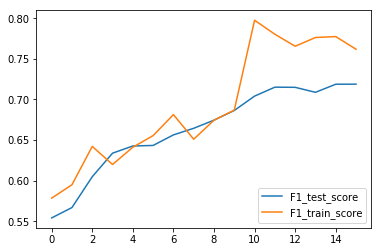

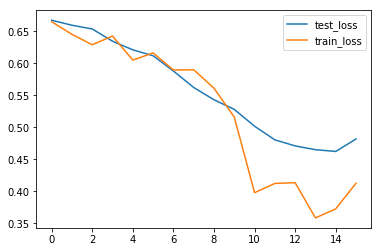

In [33]:
###############set learning rate to 0.000004, trainingset = 1100, testing set = 300
##########hidden size 512, 256, 128
#########many to one 2nd place model + LSTM
plt.plot(range(len(F1_test)),F1_test,label='F1_test_score')
plt.plot(range(len(F1_train)),F1_train,label='F1_train_score')
plt.legend(loc = 'lower right')
plt.show()
plt.plot(range(len(test_loss)),test_loss,label='test_loss')
plt.plot(range(len(train_loss)),train_loss,label='train_loss')
plt.legend(loc = 'upper right')
plt.show()

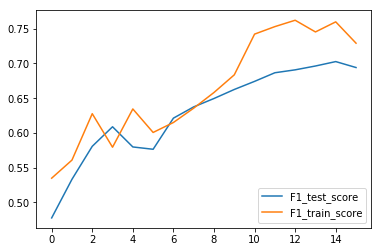

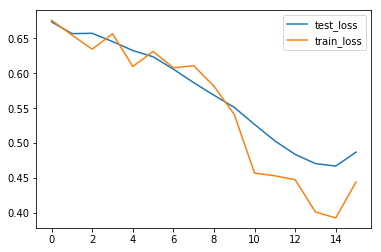

In [31]:
###############set learning rate to 0.000004, trainingset = 1100, testing set = 300
##########hidden size 512, 256, 128
#########many to one 2nd place model + LSTM
plt.plot(range(len(F1_test)),F1_test,label='F1_test_score')
plt.plot(range(len(F1_train)),F1_train,label='F1_train_score')
plt.legend(loc = 'lower right')
plt.show()
plt.plot(range(len(test_loss)),test_loss,label='test_loss')
plt.plot(range(len(train_loss)),train_loss,label='train_loss')
plt.legend(loc = 'upper right')
plt.show()

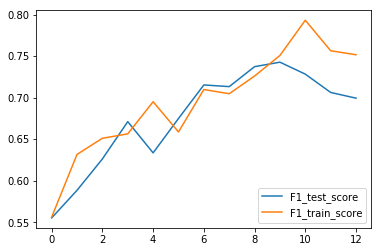

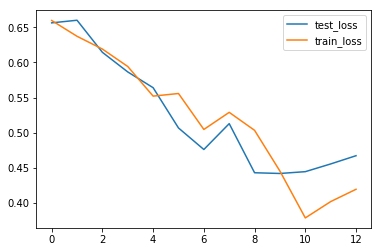

In [31]:
###############set learning rate to 0.00001, trainingset = 1000, testing set = 200
##########hidden size 512, 256, 128
#########many to one 2nd place model + LSTM
plt.plot(range(len(F1_test)),F1_test,label='F1_test_score')
plt.plot(range(len(F1_train)),F1_train,label='F1_train_score')
plt.legend(loc = 'lower right')
plt.show()
plt.plot(range(len(test_loss)),test_loss,label='test_loss')
plt.plot(range(len(train_loss)),train_loss,label='train_loss')
plt.legend(loc = 'upper right')
plt.show()

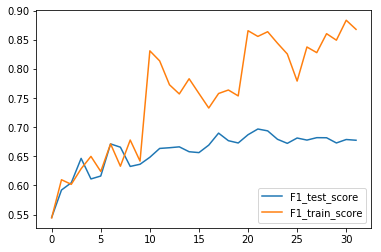

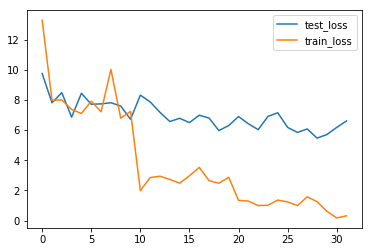

In [35]:
###############set learning rate to 0.00001, trainingset = 1000, testing set = 200
##########hidden size 512, 256, 128
#########many to one 2nd place model
plt.plot(range(len(F1_test)),F1_test,label='F1_test_score')
plt.plot(range(len(F1_train)),F1_train,label='F1_train_score')
plt.legend(loc = 'lower right')
plt.show()
plt.plot(range(len(test_loss)),test_loss,label='test_loss')
plt.plot(range(len(train_loss)),train_loss,label='train_loss')
plt.legend(loc = 'upper right')
plt.show()

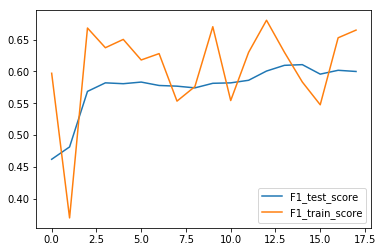

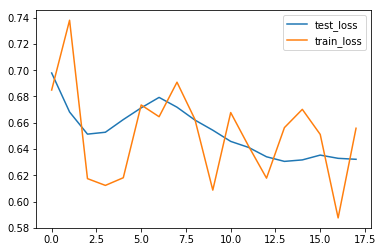

In [32]:
###############set learning rate to 0.00008, trainingset = 1000, testing set = 200
##########hidden size 512, 256, 128
#########many to one
plt.plot(range(len(F1_test)),F1_test,label='F1_test_score')
plt.plot(range(len(F1_train)),F1_train,label='F1_train_score')
plt.legend(loc = 'lower right')
plt.show()
plt.plot(range(len(test_loss)),test_loss,label='test_loss')
plt.plot(range(len(train_loss)),train_loss,label='train_loss')
plt.legend(loc = 'upper right')
plt.show()

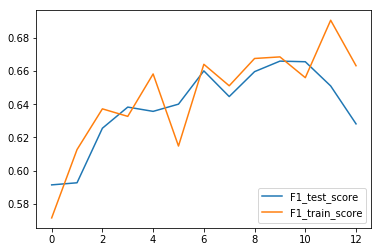

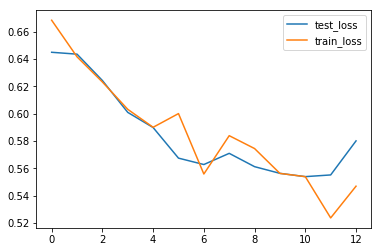

In [33]:
###############set learning rate to 0.00008, trainingset = 1000, testing set = 200
##########hidden size 512, 256, 128
#########new FC model
plt.plot(range(len(F1_test)),F1_test,label='F1_test_score')
plt.plot(range(len(F1_train)),F1_train,label='F1_train_score')
plt.legend(loc = 'lower right')
plt.show()
plt.plot(range(len(test_loss)),test_loss,label='test_loss')
plt.plot(range(len(train_loss)),train_loss,label='train_loss')
plt.legend(loc = 'upper right')
plt.show()

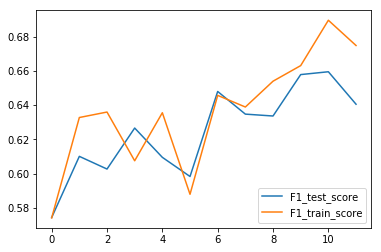

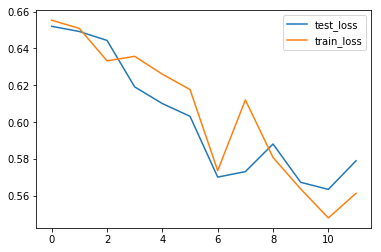

In [32]:
###############set learning rate to 0.00008, trainingset = 1000, testing set = 200
##########hidden size 512, 256, 128
plt.plot(range(len(F1_test)),F1_test,label='F1_test_score')
plt.plot(range(len(F1_train)),F1_train,label='F1_train_score')
plt.legend(loc = 'lower right')
plt.show()
plt.plot(range(len(test_loss)),test_loss,label='test_loss')
plt.plot(range(len(train_loss)),train_loss,label='train_loss')
plt.legend(loc = 'upper right')
plt.show()

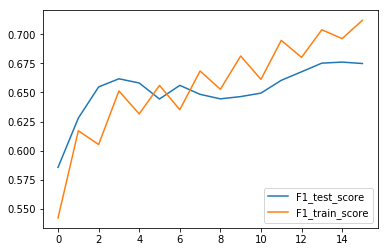

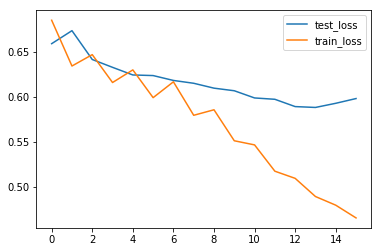

In [34]:
###############set learning rate to 0.0002, trainingset = 500, testing set = 50
plt.plot(range(len(F1_test)),F1_test,label='F1_test_score')
plt.plot(range(len(F1_train)),F1_train,label='F1_train_score')
plt.legend(loc = 'lower right')
plt.show()
plt.plot(range(len(test_loss)),test_loss,label='test_loss')
plt.plot(range(len(train_loss)),train_loss,label='train_loss')
plt.legend(loc = 'upper right')
plt.show()